# Estrategia de Inversión
Para este proyecto crearemos un plan de Inversión para elegir las 10 acciones mejor valoradas de una lista de 30, con el fin de tomar dichas 10 acciones y calcular la inversión individual en un portafolio de un tamaño variable.

Esto haciendo uso de la API de IEX Cloud asi como el algoritmo de DBScan para hallar los resultados.

## Importar Librerías
Lo primero que haremos es importar las librerias que utilizaremos para este proyecto.

In [1]:
import numpy as np
import pandas as pd
import xlsxwriter
import requests
from scipy import stats
import math
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importar Nuestra Lista de Acciones y el API Token
Trabajaremos con un archivo csv que contendra nuestra lista de acciones. Una vez hecha la referencia importamos la llave API que utilizaremos para conectar al sandbox de IEX Cloud.

In [2]:
stocks = pd.read_csv('sp_500_stocks.csv')
from secret import IEX_CLOUD_API_TOKEN

## Probamos la conexion haciendo un llamado a la API
Creamos nuestra pruba para llamar los datos de la API.

Generamos nuestro URL para obtener los datos de la API con nuestro Token ya definido.

In [9]:
symbol = 'aapl'
api_url = f'https://cloud.iexapis.com/stable/stock/{symbol}/quote?token={IEX_CLOUD_API_TOKEN}'
data = requests.get(api_url).json()
data

{'avgTotalVolume': 79487180,
 'calculationPrice': 'close',
 'change': -0.5,
 'changePercent': -0.00337,
 'close': 147.81,
 'closeSource': 'official',
 'closeTime': 1670014800448,
 'companyName': 'Apple Inc',
 'currency': 'USD',
 'delayedPrice': 147.735,
 'delayedPriceTime': 1670014786991,
 'extendedChange': -0.31,
 'extendedChangePercent': -0.0021,
 'extendedPrice': 147.5,
 'extendedPriceTime': 1670029190961,
 'high': 148,
 'highSource': '15 minute delayed price',
 'highTime': 1670014800046,
 'iexAskPrice': None,
 'iexAskSize': None,
 'iexBidPrice': None,
 'iexBidSize': None,
 'iexClose': 147.76,
 'iexCloseTime': 1670014799489,
 'iexLastUpdated': None,
 'iexMarketPercent': None,
 'iexOpen': 146.01,
 'iexOpenTime': 1669991400060,
 'iexRealtimePrice': None,
 'iexRealtimeSize': None,
 'iexVolume': None,
 'lastTradeTime': 1670014799903,
 'latestPrice': 147.81,
 'latestSource': 'Close',
 'latestTime': 'December 2, 2022',
 'latestUpdate': 1670014800448,
 'latestVolume': 65447446,
 'low': 145

## Obtenemos nuestros datos especificos
Para esta llamada API necesitaremos los datos de la Relación Precio-Ganancias 

Aqui tenemos un ejemplo de esta llamada:

In [5]:
price = data['latestPrice']
pe_ratio = data['peRatio']
pe_ratio
#price

24.19

## Ejecutamos una tanda de llamadas API para crear nuestro DataFrame
Ejecutamos una serie de llamadas API para obtener la informacion que necesitamos para nuestro Dataframe.

La siguiente funcion nos permite dividir la tanda de llamadas en grupos de hasta 100 acciones, lo que nos permite trabajar con un numero mayor de acciones dependiendo la situacion.

In [25]:
stocks = stocks[~stocks['Ticker'].isin(['DISCA', 'HFC','VIAC','WLTW'])]

# Funcion tomada de: 
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst.iloc[i:i + n]   
        
symbol_groups = list(chunks(stocks['Ticker'], 100))
symbol_strings = []
for i in range(0, len(symbol_groups)):
    symbol_strings.append(','.join(symbol_groups[i]))
#print(symbol_strings)

my_columns = ['Ticker', 'Price', 'Price-to-Earnings Ratio', 'Earning Per Share', 'Center Ratio', 'Number of Shares to Buy']

Creamos un DataFrame en blanco para contener todos los datos que necesitaremos a continuación.

In [26]:
final_dataframe = pd.DataFrame(columns = my_columns)

for symbol_string in symbol_strings:
#     print(symbol_strings)
    batch_api_call_url = f'https://cloud.iexapis.com/stable/stock/market/batch/?types=quote&symbols={symbol_string}&token={IEX_CLOUD_API_TOKEN}'
    data = requests.get(batch_api_call_url).json()
    for symbol in symbol_string.split(','):
        final_dataframe = final_dataframe.append(
                                        pd.Series([symbol, 
                                                   data[symbol]['quote']['latestPrice'],
                                                   data[symbol]['quote']['peRatio'],
                                                   'N/A',
                                                   'N/A',
                                                   'N/A'
                                                   ], 
                                                  index = my_columns), 
                                        ignore_index = True)
        
    
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,A,155.67,35.46,N/A,N/A,N/A
1,AAL,13.97,-5.75,N/A,N/A,N/A
2,AAP,153.03,17.79,N/A,N/A,N/A
3,AAPL,147.81,24.19,N/A,N/A,N/A
4,ABBV,163.66,21.79,N/A,N/A,N/A
...,...,...,...,...,...,...
496,YUM,129.68,29.47,N/A,N/A,N/A
497,ZBH,122.97,93.87,N/A,N/A,N/A
498,ZBRA,274.86,30.81,N/A,N/A,N/A
499,ZION,52.25,5.87,N/A,N/A,N/A


## Filtro de Acciones

Una vez obtenida la lista de acciones, procedemos a filtar las acciones. 

Por lo que nuestro siguiente paso es eliminar aquellas acciones con valores Precio-Ganancia negativos de nuesto DataFrame. Una vez eliminadas dichas acciones seleccionamos 30 de los datos filtrados.

In [27]:
final_dataframe.sort_values('Price-to-Earnings Ratio', inplace = True)
final_dataframe = final_dataframe[final_dataframe['Price-to-Earnings Ratio'] > 0]
final_dataframe = final_dataframe[:30]
final_dataframe.reset_index(inplace = True)
final_dataframe.drop('index', axis=1, inplace = True)
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,AIG,62.75,3.71,N/A,N/A,N/A
1,APA,47.11,4.5,N/A,N/A,N/A
2,AIV,8.25,4.51,N/A,N/A,N/A
3,PFG,92.18,4.53,N/A,N/A,N/A
4,PHM,44.59,4.54,N/A,N/A,N/A
5,PSX,106.66,4.77,N/A,N/A,N/A
6,MOS,49.31,4.82,N/A,N/A,N/A
7,COF,97.69,4.82,N/A,N/A,N/A
8,NUE,154.20,4.85,N/A,N/A,N/A
9,HPQ,29.64,5.09,N/A,N/A,N/A


Calculamos la ganancia por accion, que nos permitira obtener nuestra grafica para aplicar el algoritmo de DBScan.

In [28]:
for i in range(0, len(final_dataframe['Ticker'])):
    final_dataframe.loc[i, 'Earning Per Share'] = math.floor(float(final_dataframe['Price-to-Earnings Ratio'][i]) * final_dataframe['Price'][i])
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,AIG,62.75,3.71,232,N/A,N/A
1,APA,47.11,4.5,211,N/A,N/A
2,AIV,8.25,4.51,37,N/A,N/A
3,PFG,92.18,4.53,417,N/A,N/A
4,PHM,44.59,4.54,202,N/A,N/A
5,PSX,106.66,4.77,508,N/A,N/A
6,MOS,49.31,4.82,237,N/A,N/A
7,COF,97.69,4.82,470,N/A,N/A
8,NUE,154.20,4.85,747,N/A,N/A
9,HPQ,29.64,5.09,150,N/A,N/A


## Generamos la gráfica
Haciendo uso de la libreria de Matplotlib, agregamos los datos de nuestras acciones tomando los datos del precio y ganancias en el eje x y y respectivamente. Mismos que seran identificados con los puntos azules.

Ademas de esto calculado a la media de ambos datos para posicionar nuestro centroide.

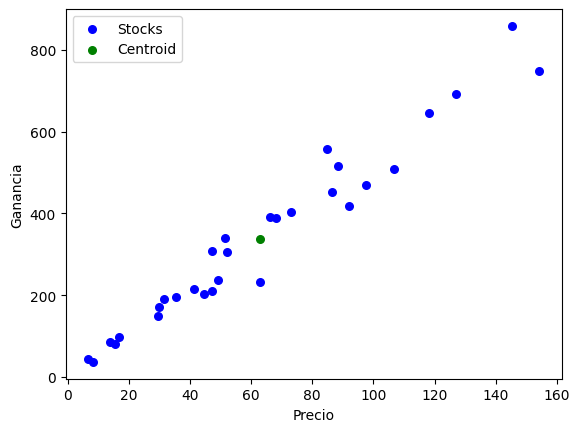

In [20]:
#x = [1,2,3,4,5,6,7,8,9,10]

#y = [2,4,5,7,6,8,9,11,12,12]

x = final_dataframe['Price'].values.tolist()

y = final_dataframe['Earning Per Share'].values.tolist()

p_mean = final_dataframe['Price'].values.mean()

e_mean = final_dataframe['Earning Per Share'].values.mean()

plt.scatter(x, y, label= "Stocks", color= "blue",
           marker= "o", s= 30)

plt.scatter(p_mean, e_mean, label= "Centroid", color= "green",
           marker= "o", s= 30)

plt.xlabel('Precio')

plt.ylabel('Ganancia')

plt.legend()

plt.show()

## Calulamos la distancia Euclideana
Con los datos de la grafica, podemos empezar a realizar el calculo de la distancia euclideana

In [30]:
point1 = np.array((p_mean, e_mean))
#point1

for i in range(0, len(final_dataframe['Ticker'])):
    point2 = np.array((final_dataframe['Price'][i],final_dataframe['Earning Per Share'][i]))
    dist = np.linalg.norm(point1 - point2)
    final_dataframe.loc[i, 'Center Ratio'] = math.floor(dist)
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,AIG,62.75,3.71,232,106,N/A
1,APA,47.11,4.5,211,128,N/A
2,AIV,8.25,4.51,37,306,N/A
3,PFG,92.18,4.53,417,83,N/A
4,PHM,44.59,4.54,202,137,N/A
5,PSX,106.66,4.77,508,175,N/A
6,MOS,49.31,4.82,237,102,N/A
7,COF,97.69,4.82,470,136,N/A
8,NUE,154.20,4.85,747,418,N/A
9,HPQ,29.64,5.09,150,191,N/A


Una vez calculada la distancia euclidiana, tomamos los valores que se acerquen mas a nuestro centroide, tomando solamente los 10 primeros.

In [52]:
final_dataframe.sort_values('Center Ratio', inplace = True)
final_dataframe = final_dataframe[:10]
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,DOW,51.55,6.63,341,11,N/A
1,ZION,52.25,5.87,306,33,N/A
2,C,47.24,6.5,307,35,N/A
3,OXY,68.21,5.69,388,50,N/A
4,TSN,66.02,5.92,390,51,N/A
5,PVH,72.93,5.53,403,65,N/A
6,PFG,92.18,4.53,417,83,N/A
7,MOS,49.31,4.82,237,102,N/A
8,AIG,62.75,3.71,232,106,N/A
9,DHI,86.33,5.23,451,115,N/A


## Calculamos el numero de acciones a comprar
Ahora tenemos que obtener el numero de acciones que debemos comprar

Para esto usaremos la funcion `portfolio_input` que nos permitira saber el tamaño del portafolio para obtener los calculos necesarios.

In [57]:
def portfolio_input():
    global portfolio_size
    portfolio_size = input("Ingresa el valor de tu portafolio:")

    try:
        val = float(portfolio_size)
    except ValueError:
        print("Ese no es un número! \n Intentalo de nuevo:")
        portfolio_size = input("Ingresa el valor de tu portafolio:")

Usa la funcion `portfolio_input` para aceptar el tamaño de la variable `portfolio_size`.

In [58]:
portfolio_input()

Ingresa el valor de tu portafolio:100000


Ahora puedes usar la variable `portfolio_size` el numero de acciones que nuestra estrategia va a comprar.

In [59]:
position_size = float(portfolio_size) / len(final_dataframe.index)
for i in range(0, len(final_dataframe['Ticker'])):
    final_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / final_dataframe['Price'][i])
final_dataframe

,Ticker,Price,Price-to-Earnings Ratio,Earning Per Share,Center Ratio,Number of Shares to Buy
0,DOW,51.55,6.63,341,11,193
1,ZION,52.25,5.87,306,33,191
2,C,47.24,6.5,307,35,211
3,OXY,68.21,5.69,388,50,146
4,TSN,66.02,5.92,390,51,151
5,PVH,72.93,5.53,403,65,137
6,PFG,92.18,4.53,417,83,108
7,MOS,49.31,4.82,237,102,202
8,AIG,62.75,3.71,232,106,159
9,DHI,86.33,5.23,451,115,115


## Creando el formato de nuestra salida Excel

Haremos uso de la libreria XlsxWriter para Python para crear archivos en formato Excel. Transformando asi nuestro Dataframe en un archivo Excel con mejor presentación.

In [78]:
writer = pd.ExcelWriter('Investing_strategy.xlsx', engine='xlsxwriter')
final_dataframe.to_excel(writer, sheet_name='Investing Strategy', index = False)

In [74]:
background_color = '#0a0a23'
font_color = '#ffffff'

string_template = writer.book.add_format(
        {
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

dollar_template = writer.book.add_format(
        {
            'num_format':'$0.00',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

integer_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

float_template = writer.book.add_format(
        {
            'num_format':'0',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

percent_template = writer.book.add_format(
        {
            'num_format':'0.0%',
            'font_color': font_color,
            'bg_color': background_color,
            'border': 1
        }
    )

In [77]:
column_formats = {
                    'A': ['Ticker', string_template],
                    'B': ['Price', dollar_template],
                    'C': ['Price-to-Earnings Ratio', float_template],
                    'D': ['Earning Per Share', integer_template],
                    'E': ['Center Ratio', integer_template],
                    'F': ['Number of Shares to Buy', integer_template]
                }

for column in column_formats.keys():
    writer.sheets['Investing Strategy'].set_column(f'{column}:{column}', 25, column_formats[column][1])
    writer.sheets['Investing Strategy'].write(f'{column}1', column_formats[column][0], column_formats[column][1])

    
writer.save()    

## Guardamos nuestro archivo Excel
Para guardar nuestro archivo terminado, solamente ejecutamos el siguiente comando:

In [76]:
writer.save()